# Project Name

---

## Table of Contents <a name="toc"></a>

---

- 1.[**Data Source Information**](#datasource)
- 2.[**Setup**](#setup)
  - 2.1. [Environment Details for Reproducility](#env)
  - 2.2. [Importing the Data](#dataimport)
- 3.[**Data Preprocessing**](#datapre)


## 1. Data Source Information <a name="datasource"></a>

---


## 2. Setup <a name="setup"></a>

---


In [68]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### 2.1. Environment Information for Reproducibility: <a name="env"></a>

### 2.2. Importing the Data: <a name="dataimport"></a>

In [69]:
# Set directories
current_wdir = os.getcwd()
data_folder_hourly = current_wdir + '/Data/Hourly_Load'
data_folder_gen = current_wdir + '/Data/Gen_by_Fuel'

## 3. Data Preprocessing <a name="datapre"></a>

---

In [70]:
file_path_load = [f'{data_folder_hourly}/{file}' for file in os.listdir(data_folder_hourly) if '.csv' in file]
file_path_load = sorted(file_path_load)

file_path_gen = [f'{data_folder_gen}/{file}' for file in os.listdir(data_folder_gen) if '.csv' in file]
file_path_gen = sorted(file_path_gen)

# pd.read_csv can unzip as it goes with compression argument.
load_df = pd.concat([pd.read_csv(file, compression = 'gzip') for file in file_path_load], join = 'outer', ignore_index = False, axis = 0)
gen_df = pd.concat([pd.read_csv(file, compression = 'gzip') for file in file_path_gen], join = 'outer', ignore_index = False, axis = 0)

In [71]:
display(load_df)
display(load_df.dtypes)

,datetime_beginning_utc,datetime_beginning_ept,nerc_region,mkt_region,zone,load_area,mw,is_verified
0,1/1/1993 5:00:00 AM,1/1/1993 12:00:00 AM,PJM RTO,PJM,BC,BC,2358.000,True
1,1/1/1993 5:00:00 AM,1/1/1993 12:00:00 AM,PJM RTO,PJM,CNCT,AE,855.000,True
2,1/1/1993 5:00:00 AM,1/1/1993 12:00:00 AM,PJM RTO,PJM,CNCT,DPL,1150.000,True
3,1/1/1993 5:00:00 AM,1/1/1993 12:00:00 AM,PJM RTO,PJM,GPU,JC,1632.000,True
4,1/1/1993 5:00:00 AM,1/1/1993 12:00:00 AM,PJM RTO,PJM,GPU,ME,929.000,True
...,...,...,...,...,...,...,...,...
62605,3/28/2024 3:00:00 AM,3/27/2024 11:00:00 PM,RFC,MIDATL,RECO,RECO,131.877,False
62606,3/28/2024 3:00:00 AM,3/27/2024 11:00:00 PM,RFC,MIDATL,PEP,SMECO,355.931,False
62607,3/28/2024 3:00:00 AM,3/27/2024 11:00:00 PM,RFC,MIDATL,PL,UGI,101.478,True
62608,3/28/2024 3:00:00 AM,3/27/2024 11:00:00 PM,RFC,MIDATL,AE,VMEU,70.051,False


datetime_beginning_utc     object
datetime_beginning_ept     object
nerc_region                object
mkt_region                 object
zone                       object
load_area                  object
mw                        float64
is_verified                  bool
dtype: object

In [72]:
display(gen_df)
display(gen_df.dtypes)

,datetime_beginning_utc,datetime_beginning_ept,fuel_type,mw,fuel_percentage_of_total,is_renewable
0,1/1/2017 4:00:00 AM,12/31/2016 11:00:00 PM,Coal,34820,0.41,False
1,1/1/2017 4:00:00 AM,12/31/2016 11:00:00 PM,Gas,11169,0.13,False
2,1/1/2017 4:00:00 AM,12/31/2016 11:00:00 PM,Hydro,699,0.01,True
3,1/1/2017 4:00:00 AM,12/31/2016 11:00:00 PM,Multiple Fuels,266,0.00,False
4,1/1/2017 4:00:00 AM,12/31/2016 11:00:00 PM,Nuclear,34269,0.41,False
...,...,...,...,...,...,...
21095,1/1/2024 5:00:00 AM,1/1/2024 12:00:00 AM,Oil,221,0.00,False
21096,1/1/2024 5:00:00 AM,1/1/2024 12:00:00 AM,Other Renewables,690,0.01,True
21097,1/1/2024 5:00:00 AM,1/1/2024 12:00:00 AM,Solar,12,0.00,True
21098,1/1/2024 5:00:00 AM,1/1/2024 12:00:00 AM,Storage,0,0.00,False


datetime_beginning_utc       object
datetime_beginning_ept       object
fuel_type                    object
mw                            int64
fuel_percentage_of_total    float64
is_renewable                   bool
dtype: object

In [73]:
date_cols = ['datetime_beginning_utc', 'datetime_beginning_ept']
load_df[date_cols] = load_df[date_cols].apply(pd.to_datetime, format = '%m/%d/%Y %I:%M:%S %p', utc = False)
gen_df[date_cols] = gen_df[date_cols].apply(pd.to_datetime, format = '%m/%d/%Y %I:%M:%S %p', utc = False)

In [74]:
sorted(load_df['zone'].unique())

['AE',
 'AEP',
 'AP',
 'ATSI',
 'BC',
 'CE',
 'CNCT',
 'DAY',
 'DEOK',
 'DOM',
 'DPL',
 'DUQ',
 'EKPC',
 'GPU',
 'JC',
 'ME',
 'OVEC',
 'PE',
 'PEP',
 'PL',
 'PN',
 'PS',
 'RECO',
 'RTO']

In [75]:
load_zone_df = load_df[['datetime_beginning_ept', 'zone', 'mw']].groupby(['datetime_beginning_ept', 'zone'], as_index = False).sum()

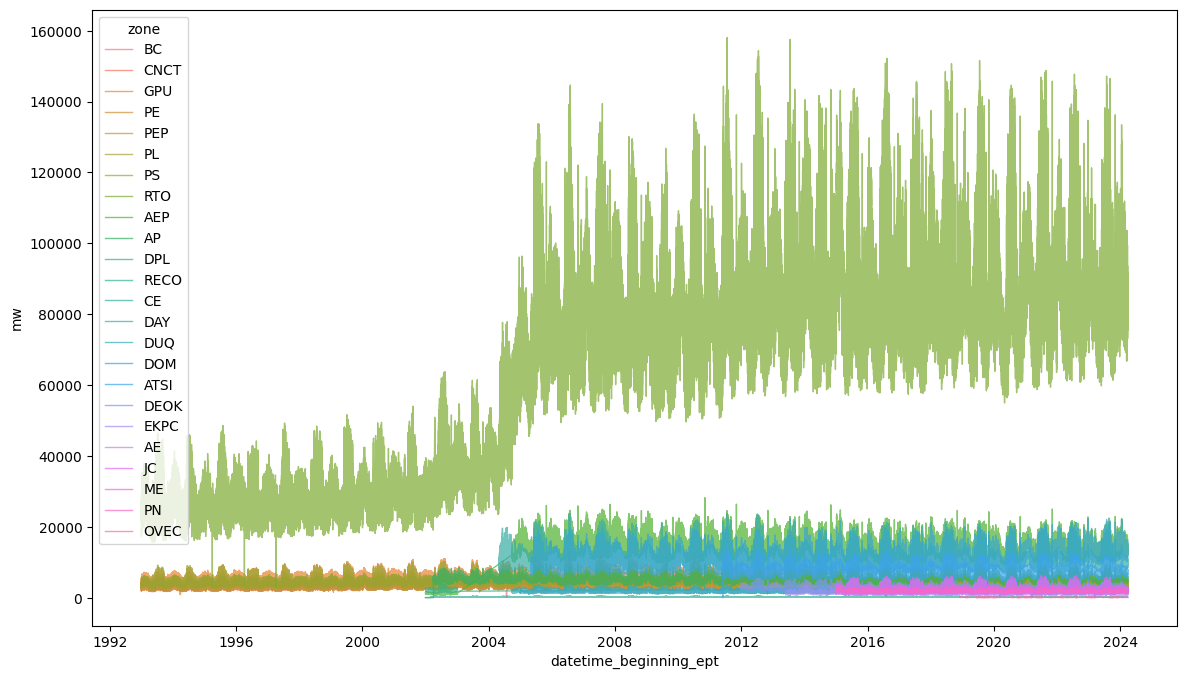

In [88]:
ax, fig = plt.subplots(figsize = (14, 8))
ax = sns.lineplot(load_zone_df, x = 'datetime_beginning_ept', y = 'mw',  hue = 'zone', alpha = 0.7, lw = 1)

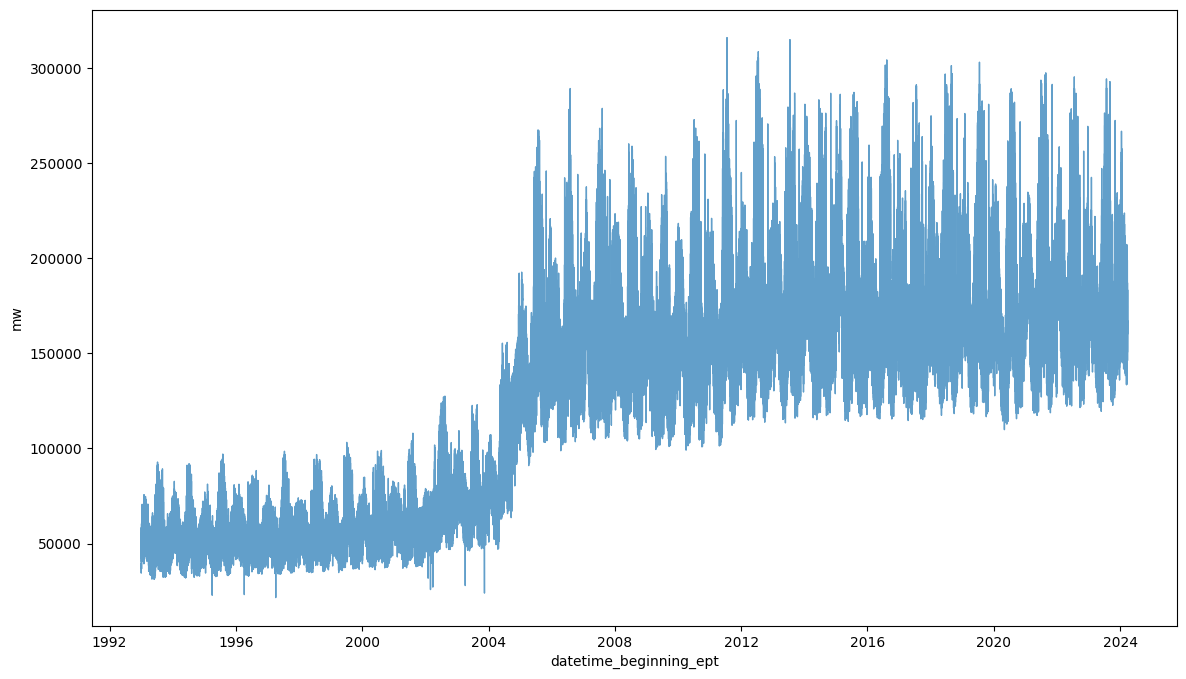

In [87]:

ax, fig = plt.subplots(figsize = (14, 8))
ax = sns.lineplot(load_df[['datetime_beginning_ept', 'mw']].groupby(['datetime_beginning_ept'], as_index = False).sum(), 
                  x = 'datetime_beginning_ept', 
                  y = 'mw',  
                  alpha = 0.7, lw = 1)

In [ ]:
gen_fuel_df = gen_df[['datetime_beginning_ept', 'fuel_type', 'mw']].groupby(['datetime_beginning_ept', 'fuel_type'], as_index = False).sum()

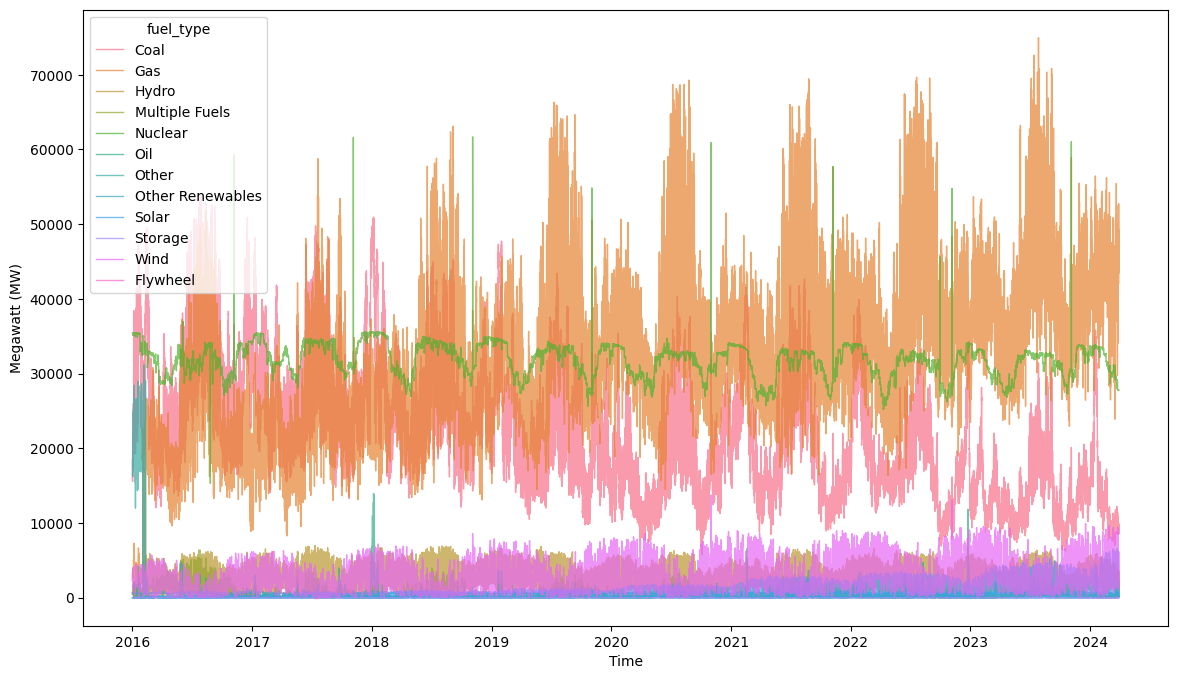

In [84]:
ax, fig = plt.subplots(figsize = (14, 8))
ax = sns.lineplot(gen_fuel_df, x = 'datetime_beginning_ept', y = 'mw',  hue = 'fuel_type', alpha = 0.7, lw = 1)
ax.set_xlabel('Time')
ax.set_ylabel('Megawatt (MW)')
plt.show()

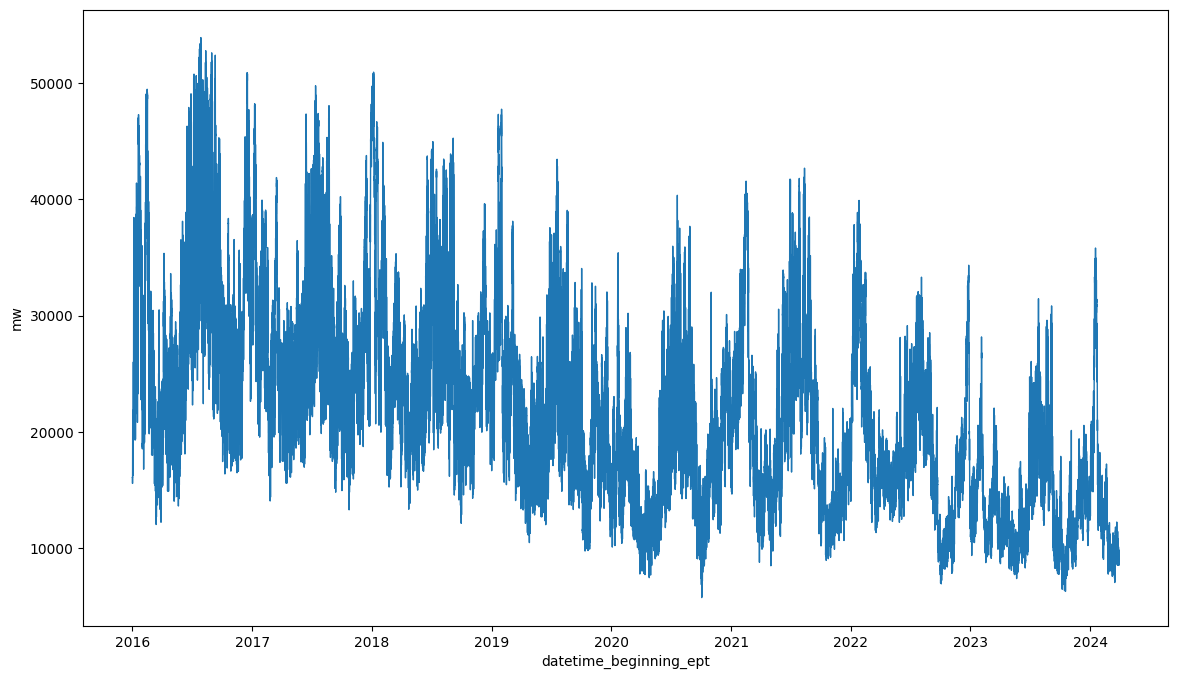

In [85]:
ax, fig = plt.subplots(figsize = (14, 8))
ax = sns.lineplot(gen_fuel_df.loc[gen_fuel_df['fuel_type'] == 'Coal'], x = 'datetime_beginning_ept', y = 'mw', lw = 1)

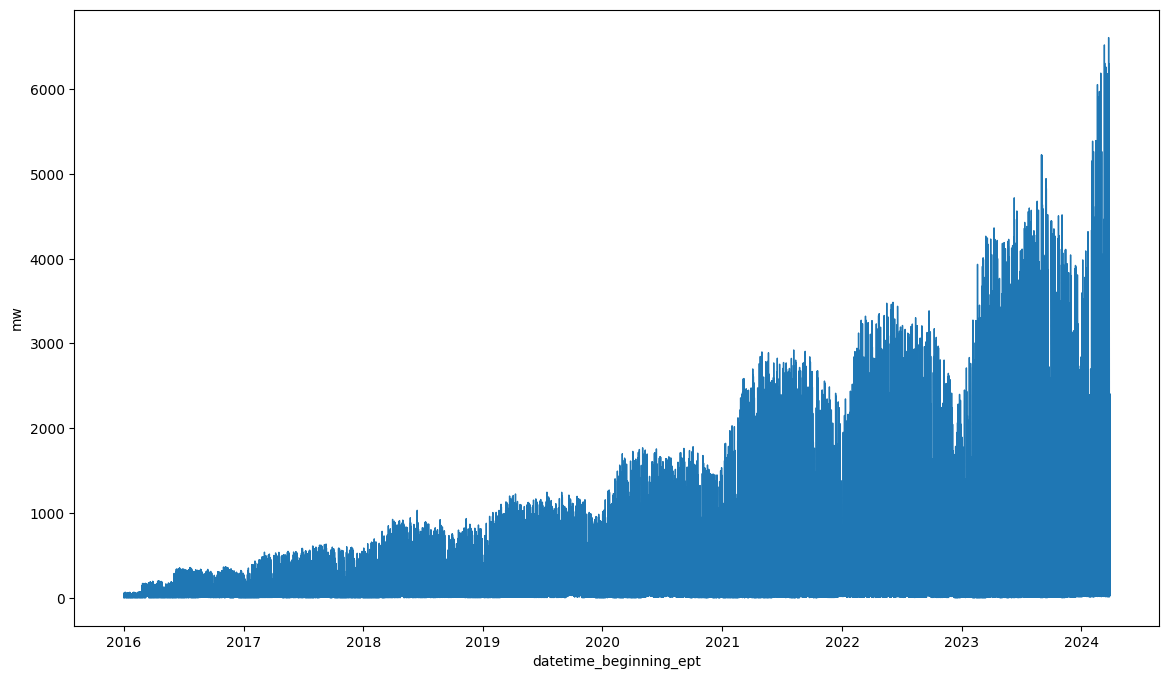

In [86]:
ax, fig = plt.subplots(figsize = (14, 8))
ax = sns.lineplot(gen_fuel_df.loc[gen_fuel_df['fuel_type'] == 'Solar'], x = 'datetime_beginning_ept', y = 'mw', lw = 1)